In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [9]:
os.chdir('/Users/elizabeth/Desktop/BMI203_HW3/data')

In [43]:
read_scoring_matrix("scoring/BLOSUM50").shape

(24, 24)

In [22]:
def read_pairs(file):
    #Open the file
    f = open ( file , 'r')
    #Read all the lines
    lines = f.read().splitlines()
    #Create a list of the paired filenames
    files = [line.split()for line in lines]
    return files

def read_sequence(file):
    #Store protein name
    protein_name = file.split('/')[-1][:-3]
    #Open the file
    f = open ( file , 'r')
    #Read all the lines
    lines = f.read().splitlines()
    #Remove the header
    lines = lines[1:]
    #Initialize array to store sequence
    sequence = ''
    for line in lines:
        sequence = sequence + line
    sequence = sequence.upper()
    return protein_name, sequence

def read_scoring_matrix(file):

    #Open the file
    f = open ( file , 'r')
    #Read all the lines
    lines = f.read().splitlines()
    #Find where the header ends
    aa_names_index = 0
    while lines[aa_names_index][0] == '#':
        aa_names_index = aa_names_index +1
    #Remove header
    lines = lines[aa_names_index:]
    #Initialize DataFrame to store scoring matrix
    amino_acids = lines[0].split()
    scoring_df = pd.DataFrame(index=amino_acids, columns=amino_acids)
    #Store scores into dataframe
    for line_index in range(1,len(lines)):
        scoring_df.iloc[line_index-1] = lines[line_index].split()
    #Convert scores to numbers from strings
    scoring_df = scoring_df.apply(pd.to_numeric)   
    return scoring_df

In [23]:
read_sequence('/Users/elizabeth/Desktop/BMI203_HW3/data/sequences/prot-0004.fa')

('prot-0004',
 'SLEAAQKSNVTSSWAKASAAWGTAGPEFFMALFDAHDDVFAKFSGLFSGAAKGTVKNTPEMAAQAQSFKGLVSNWVDNLDNAGALEGQCKTFAANHKARGISAGQLEAAFKVLSGFMKSYGGDEGAWTAVAGALMGEIEPDM')

In [10]:
pos_pairs = read_pairs('pairs/Pospairs.txt')
neg_pairs = read_pairs('pairs/Negpairs.txt')
fp_result = []
start = time.time()
for gap in range(15,21):
    for ext in range(1,6):
        pos_scores = [smith_waterman(x[0], x[1], 'scoring/BLOSUM50', gap, ext) for x in pos_pairs]
        neg_scores = [smith_waterman(x[0], x[1], 'scoring/BLOSUM50', gap, ext) for x in neg_pairs]
        #Threshold for 0.7 True Positive Rate. (there are 50 Pos_pairs)
        threshold = sorted(pos_scores)[14]
        false_pos = np.sum(np.array(neg_scores) > threshold)/len(neg_scores)
        true_pos = np.sum(np.array(pos_scores) > threshold)/len(pos_scores)
        fp_result.append([gap,ext,false_pos,true_pos])
        print("finished for ",gap,ext,time.time()-start)

KeyboardInterrupt: 

In [20]:
os.getcwd()

'/Users/elizabeth/Desktop/BMI203_HW3/data'

In [6]:
def read_pairs(file):
    #Open the file
    f = open ( file , 'r')
    #Read all the lines
    lines = f.read().splitlines()
    #Create a list of the paired filenames
    files = [line.split()for line in lines]
    return files

def read_sequence(file):
    #Store protein name
    protein_name = file.split('/')[-1][:-3]
    #Open the file
    f = open ( file , 'r')
    #Read all the lines
    lines = f.read().splitlines()
    #Remove the header
    lines = lines[1:]
    #Initialize array to store sequence
    sequence = ''
    for line in lines:
        sequence = sequence + line
    sequence = sequence.upper()
    return protein_name, sequence

def read_scoring_matrix(file):

    #Open the file
    f = open ( file , 'r')
    #Read all the lines
    lines = f.read().splitlines()
    #Find where the header ends
    aa_names_index = 0
    while lines[aa_names_index][0] == '#':
        aa_names_index = aa_names_index +1
    #Remove header
    lines = lines[aa_names_index:]
    #Initialize DataFrame to store scoring matrix
    amino_acids = lines[0].split()
    scoring_df = pd.DataFrame(index=amino_acids, columns=amino_acids)
    #Store scores into dataframe
    for line_index in range(1,len(lines)):
        scoring_df.iloc[line_index-1] = lines[line_index].split()
    #Convert scores to numbers from strings
    scoring_df = scoring_df.apply(pd.to_numeric)   
    return scoring_df

def smith_waterman_alignment(path_seq_a, path_seq_b, path_scoring_matrix, gap_open, gap_extend):
    #Read sequences and scoring matrix
    name_a, seq_a = read_sequence(path_seq_a)
    name_b, seq_b = read_sequence(path_seq_b)
    cost_matrix = read_scoring_matrix(path_scoring_matrix)
    
    #Store value for -Inf
    MIN = -float("inf")
    
    """
    We will initialize the values for three matrices:
    A - score for aligning seq_a and seq_b up to i,j with a gap in seq_a at position i
    B - score for aligning seq_a and seq_b up to i,j with a gap in seq_b at position j
    M - score for aligning seq_a and seq_b with a alignment at position i,j
    """
    dim_a = len(seq_a)+1
    dim_b = len(seq_b)+1
    
    ####Initialize matrices
    
    A = np.zeros((dim_a, dim_b))
    B = np.zeros((dim_a, dim_b))
    M = np.zeros((dim_a, dim_b))
    
    A_direction = {}
    B_direction = {}
    M_direction = {}
    for i in range(dim_a):
        A_direction[i,0] = "end"
        B_direction[i,0] = "end"
        M_direction[i,0] = "end"
    for j in range(dim_b):
        A_direction[0,j] = "end"
        B_direction[0,j] = "end"
        M_direction[0,j] = "end"

    #Fill in top row and left row for each gap matrix with -Inf because we will not allow
    #a gap at the start for our local alignment
    for i in range(1,dim_a):
        A[i,0] = MIN
        B[i,0] = MIN
    for j in range(1,dim_b):
        A[0,j] = MIN
        B[0,j] = MIN


    #Make list to keep track of direction
    event_gap_a = ["open_gap_a", "extend_gap_a", "open_gap_a_from_b"]
    event_gap_b = ["open_gap_b", "extend_gap_b", "open_gap_b_from_a"]
    event_match = ["match", "close_gap_a","close_gap_b","end"]
    """
    Now we will fill in the values for these three matrices
    """
        

    for i in range(1,dim_a):
        for j in range(1,dim_b):
            #For A (putting a gap in seq_a at position i), we have three possibilities for how seq_a up to i
            #and seq_b up to j-1 (since j is aligning to the gap in seq_a) could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a
            # 3) a previous gap in seq_b (so a new gap in seq_a)
            #dic_A["M":M[i,j-1] + gap_open + gap_extend, "A":gap_extend + A[i,j-1]]
            values = [M[i,j-1] - gap_open - gap_extend ,  A[i,j-1] - gap_extend, B[i,j-1] - gap_open - gap_extend]
            A[i,j] = max(values)
            A_direction[i,j] = event_gap_a[values.index(A[i,j])]
            #For B (putting a gap in seq_b at position j), we have three possibilities for how seq_a up to i-1 (since
            # i is aligning with a gap) and seq_b up to j could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a (so a new gap in seq_b)
            # 3) a previous gap in seq_b 
            values = [M[i-1,j] - gap_open - gap_extend , B[i-1,j] - gap_extend, A[i-1,j] - gap_open - gap_extend, ]
            B[i,j] = max(values)
            B_direction[i,j] = event_gap_b[values.index(B[i,j])]
            #For M alinging position i and j from seq_a and seq_b respectively we can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a 
            # 3) a previous gap in seq_b
            #Cost for aligning seq_a and seq_b at position i,j (need to account for zero indexing)
            #Let 0 be the minimum score in order to create local rather than global optimum alignments
            values = [cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + M[i-1,j-1], cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + A[i-1,j-1], cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + B[i-1,j-1],0]
            M[i,j] = max(values)
            M_direction[i,j] = event_match[values.index(max(values))]
    if M.max() == 0:
        return "","",0

    #Do traceback to get aligned sequence
    #Initalize strings to contan alignment

    #Find index of max score position in Z
    indices = np.where(M == M.max())
    
    #If there are multiple alignments take the first position
    index_a = indices[0][0]
    index_b = indices[1][0]
    #Store first traceback value and initial direction
    alignment_seqa, alignment_seqb = seq_a[index_a-1], seq_b[index_b-1]
    direction = M_direction[index_a,index_b]
    
    #Do traceback and store sequence
    #direction_dictionary = {"M":M_direction,"A":A_direction,"B":B_direction}
    #for i in range(30):
    while M[index_a,index_b] != 0:
        #Move in recorded direction and update alligned sequence
        #print(direction)
        if index_a == 1 or index_b == 1:
            break
        elif direction == 'close_gap_a':
            index_a, index_b = index_a-1, index_b-1
            alignment_seqa, alignment_seqb = "-"+ alignment_seqa, seq_b[index_b-1]+ alignment_seqb
            direction = A_direction[index_a, index_b]
        elif direction == 'close_gap_b':
            index_a, index_b = index_a-1, index_b-1
            alignment_seqa, alignment_seqb = seq_a[index_a-1]+ alignment_seqa, "-"+ alignment_seqb
            direction = B_direction[index_a, index_b]
        elif direction == 'match':
            index_a, index_b = index_a-1, index_b-1
            alignment_seqa, alignment_seqb = seq_a[index_a-1] + alignment_seqa, seq_b[index_b-1]+ alignment_seqb
            direction = M_direction[index_a, index_b]
        elif direction == 'end':
            break
        elif direction == 'open_gap_a':
            index_a, index_b = index_a, index_b-1
            alignment_seqa, alignment_seqb = seq_a[index_a-1]+ alignment_seqa,seq_b[index_b-1]+ alignment_seqb
            direction = M_direction[index_a, index_b]
        elif direction == 'extend_gap_a':
            index_a, index_b = index_a, index_b-1
            alignment_seqa, alignment_seqb = "-"+ alignment_seqa,seq_b[index_b-1]+ alignment_seqb
            direction = A_direction[index_a, index_b]
        elif direction == 'open_gap_a_from_b':
            index_a, index_b = index_a, index_b-1
            alignment_seqa, alignment_seqb = seq_a[index_a-1]+ alignment_seqa,"-"+ alignment_seqb
            direction = B_direction[index_a, index_b]
        elif direction == 'open_gap_b':
            index_a, index_b = index_a-1, index_b
            alignment_seqa, alignment_seqb = seq_a[index_a-1]+ alignment_seqa,seq_b[index_b-1]+ alignment_seqb
            direction = M_direction[index_a, index_b]
        elif direction == 'extend_gap_b':
            index_a, index_b = index_a-1, index_b
            alignment_seqa, alignment_seqb = seq_a[index_a-1]+ alignment_seqa,"-"+ alignment_seqb
            direction = B_direction[index_a, index_b]
        elif direction == 'open_gap_b_from_a':
            index_a, index_b = index_a-1, index_b
            alignment_seqa, alignment_seqb = "-"+ alignment_seqa,seq_b[index_b-1]+ alignment_seqb
            direction = A_direction[index_a, index_b]
        
    return alignment_seqa, alignment_seqb, M.max()
def smith_waterman(path_seq_a, path_seq_b, path_scoring_matrix, gap_open, gap_extend):
    #Read sequences and scoring matrix
    name_a, seq_a = read_sequence(path_seq_a)
    name_b, seq_b = read_sequence(path_seq_b)
    cost_matrix = read_scoring_matrix(path_scoring_matrix)
    
    #Store value for -Inf
    MIN = -float("inf")
    
    """
    We will initialize the values for three matrices:
    A - score for aligning seq_a and seq_b up to i,j with a gap in seq_a at position i
    B - score for aligning seq_a and seq_b up to i,j with a gap in seq_b at position j
    M - score for aligning seq_a and seq_b with a alignment at position i,j
    """
    dim_a = len(seq_a)+1
    dim_b = len(seq_b)+1
    
    ####Initialize matrices
    
    A = np.zeros((dim_a, dim_b))
    B = np.zeros((dim_a, dim_b))
    M = np.zeros((dim_a, dim_b))

    #Fill in top row and left row for each gap matrix with -Inf because we will not allow
    #a gap at the start for our local alignment
    for i in range(1,dim_a):
        A[i,0] = MIN
        B[i,0] = MIN
    for j in range(1,dim_b):
        A[0,j] = MIN
        B[0,j] = MIN

    """
    Now we will fill in the values for these three matrices
    """
        

    for i in range(1,dim_a):
        for j in range(1,dim_b):
            #For A (putting a gap in seq_a at position i), we have three possibilities for how seq_a up to i
            #and seq_b up to j-1 (since j is aligning to the gap in seq_a) could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a
            # 3) a previous gap in seq_b (so a new gap in seq_a)
            #dic_A["M":M[i,j-1] + gap_open + gap_extend, "A":gap_extend + A[i,j-1]]
            values = [M[i,j-1] - gap_open - gap_extend ,  A[i,j-1] - gap_extend, B[i,j-1] - gap_open - gap_extend]
            A[i,j] = max(values)

            #For B (putting a gap in seq_b at position j), we have three possibilities for how seq_a up to i-1 (since
            # i is aligning with a gap) and seq_b up to j could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a (so a new gap in seq_b)
            # 3) a previous gap in seq_b 
            values = [M[i-1,j] - gap_open - gap_extend , B[i-1,j] - gap_extend, A[i-1,j] - gap_open - gap_extend, ]
            B[i,j] = max(values)

            #For M alinging position i and j from seq_a and seq_b respectively we can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a 
            # 3) a previous gap in seq_b
            #Cost for aligning seq_a and seq_b at position i,j (need to account for zero indexing)
            #Let 0 be the minimum score in order to create local rather than global optimum alignments
            values = [cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + M[i-1,j-1], cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + A[i-1,j-1], cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + B[i-1,j-1],0]
            M[i,j] = max(values)
    return np.max(M)

def smith_waterman_opt_matrix(path_seq_a, path_seq_b, scoring_matrix, gap_open, gap_extend):
    #Read sequences and scoring matrix
    name_a, seq_a = read_sequence(path_seq_a)
    name_b, seq_b = read_sequence(path_seq_b)
    cost_matrix = scoring_matrix
    
    #Store value for -Inf
    MIN = -float("inf")
    
    """
    We will initialize the values for three matrices:
    A - score for aligning seq_a and seq_b up to i,j with a gap in seq_a at position i
    B - score for aligning seq_a and seq_b up to i,j with a gap in seq_b at position j
    M - score for aligning seq_a and seq_b with a alignment at position i,j
    """
    dim_a = len(seq_a)+1
    dim_b = len(seq_b)+1
    
    ####Initialize matrices
    
    A = np.zeros((dim_a, dim_b))
    B = np.zeros((dim_a, dim_b))
    M = np.zeros((dim_a, dim_b))

    #Fill in top row and left row for each gap matrix with -Inf because we will not allow
    #a gap at the start for our local alignment
    for i in range(1,dim_a):
        A[i,0] = MIN
        B[i,0] = MIN
    for j in range(1,dim_b):
        A[0,j] = MIN
        B[0,j] = MIN

    """
    Now we will fill in the values for these three matrices
    """
        

    for i in range(1,dim_a):
        for j in range(1,dim_b):
            #For A (putting a gap in seq_a at position i), we have three possibilities for how seq_a up to i
            #and seq_b up to j-1 (since j is aligning to the gap in seq_a) could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a
            # 3) a previous gap in seq_b (so a new gap in seq_a)
            #dic_A["M":M[i,j-1] + gap_open + gap_extend, "A":gap_extend + A[i,j-1]]
            values = [M[i,j-1] - gap_open - gap_extend ,  A[i,j-1] - gap_extend, B[i,j-1] - gap_open - gap_extend]
            A[i,j] = max(values)

            #For B (putting a gap in seq_b at position j), we have three possibilities for how seq_a up to i-1 (since
            # i is aligning with a gap) and seq_b up to j could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a (so a new gap in seq_b)
            # 3) a previous gap in seq_b 
            values = [M[i-1,j] - gap_open - gap_extend , B[i-1,j] - gap_extend, A[i-1,j] - gap_open - gap_extend, ]
            B[i,j] = max(values)

            #For M alinging position i and j from seq_a and seq_b respectively we can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a 
            # 3) a previous gap in seq_b
            #Cost for aligning seq_a and seq_b at position i,j (need to account for zero indexing)
            #Let 0 be the minimum score in order to create local rather than global optimum alignments
            values = [cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + M[i-1,j-1], cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + A[i-1,j-1], cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + B[i-1,j-1],0]
            M[i,j] = max(values)
    return np.max(M)


def smith_waterman_len_adj(path_seq_a, path_seq_b, path_scoring_matrix, gap_open, gap_extend):
    #Read sequences and scoring matrix
    name_a, seq_a = read_sequence(path_seq_a)
    name_b, seq_b = read_sequence(path_seq_b)
    cost_matrix = read_scoring_matrix(path_scoring_matrix)
    
    #Store value for -Inf
    MIN = -float("inf")
    
    """
    We will initialize the values for three matrices:
    A - score for aligning seq_a and seq_b up to i,j with a gap in seq_a at position i
    B - score for aligning seq_a and seq_b up to i,j with a gap in seq_b at position j
    M - score for aligning seq_a and seq_b with a alignment at position i,j
    """
    dim_a = len(seq_a)+1
    dim_b = len(seq_b)+1
    
    ####Initialize matrices
    
    A = np.zeros((dim_a, dim_b))
    B = np.zeros((dim_a, dim_b))
    M = np.zeros((dim_a, dim_b))

    #Fill in top row and left row for each gap matrix with -Inf because we will not allow
    #a gap at the start for our local alignment
    for i in range(1,dim_a):
        A[i,0] = MIN
        B[i,0] = MIN
    for j in range(1,dim_b):
        A[0,j] = MIN
        B[0,j] = MIN

    """
    Now we will fill in the values for these three matrices
    """
        

    for i in range(1,dim_a):
        for j in range(1,dim_b):
            #For A (putting a gap in seq_a at position i), we have three possibilities for how seq_a up to i
            #and seq_b up to j-1 (since j is aligning to the gap in seq_a) could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a
            # 3) a previous gap in seq_b (so a new gap in seq_a)
            #dic_A["M":M[i,j-1] + gap_open + gap_extend, "A":gap_extend + A[i,j-1]]
            values = [M[i,j-1] - gap_open - gap_extend ,  A[i,j-1] - gap_extend, B[i,j-1] - gap_open - gap_extend]
            A[i,j] = max(values)

            #For B (putting a gap in seq_b at position j), we have three possibilities for how seq_a up to i-1 (since
            # i is aligning with a gap) and seq_b up to j could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a (so a new gap in seq_b)
            # 3) a previous gap in seq_b 
            values = [M[i-1,j] - gap_open - gap_extend , B[i-1,j] - gap_extend, A[i-1,j] - gap_open - gap_extend, ]
            B[i,j] = max(values)

            #For M alinging position i and j from seq_a and seq_b respectively we can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a 
            # 3) a previous gap in seq_b
            #Cost for aligning seq_a and seq_b at position i,j (need to account for zero indexing)
            #Let 0 be the minimum score in order to create local rather than global optimum alignments
            values = [cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + M[i-1,j-1], cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + A[i-1,j-1], cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + B[i-1,j-1],0]
            M[i,j] = max(values)
    return np.max(M)/min(len(seq_a),len(seq_b))

def score_alignment(seq_a, seq_b, scoring_matrix,gap,ext):
    if len(seq_a) != len(seq_b):
        return "Please return valid local alignments"
    else:
        i = 0
        score = 0
        while i in range(len(seq_a)):
            if seq_a[i] != "-" and seq_b[i] != "-":
                score = scoring_matrix.loc[seq_a[i],seq_b[i]] + score
            elif seq_a[i] == "-" and seq_b[i] != "-":
                if seq_a[i-1] != "-":
                    score = -gap -ext + score
                else:
                    score = -ext + score
            elif seq_b[i] == "-": #and seq_a[i] != "-":
                if seq_b[i-1] != "-":
                    score = -gap -ext + score
                else:
                    score = -ext + score
            elif seq_b[i] == "-" and seq_a[i] == "-":
                if seq_b[i-1] == "-" and seq_a[i-1] == "-":
                    score = -ext*2 + score
                elif seq_b[i-1] != "-" and seq_a[i-1] != "-":
                    score = -ext*2 + -gap*2 + score
                else:
                    score = -ext*2 + -gap + score
            #print(score)
            i += 1
    return score

In [ ]:
import time


def optimize_scoring_matrix(alignments_pos, alignments_neg, starting_matrix_path, gap_open, gap_ext, num_iterations)
    start = time.time()
    score_mat = read_scoring_matrix(starting_matrix_path)
    #Store original matrix
    original_mat = score_mat
    #I will perform a Monte Carlo inspired optimization
    #First create 99 additional matrices that have every entry updated 
    #with a random change between -1 and 1 from the original matrix (so a pool of 100 matrices including the 
    # original one)
    #Note: Make the new matrices symmetric!
    #Intialize the iteration matrices and iteration score lists
    iteration_mat = []
    iteration_mat.append(score_mat)
    iteration_scores = []
    original_score = score_performance(alignments_pos, alignments_neg, score_mat, gap_open, gap_ext)
    iteration_scores.append(original_score)
    for k in range(99):
        for i in range(score_mat.shape[0]):
            for j in range(i,score_mat.shape[0]):
                score_mat.iloc[i,j] = score_mat.iloc[i,j] + uniform(-1,1)
                score_mat.iloc[j,i] = score_mat.iloc[i,j]
        iteration_scores.append(score_performance(alignments_pos, alignments_neg, score_mat, gap_open, gap_ext))       
        iteration_mat.append(score_mat)
        score_mat = original_mat
    #Perform optimization with pool of matrices
    #Perform a random weighted sampling with replacement from this inital set of matrices
    #Then calculate the new scores
    #Repeat for specified number of iterations
    iteration_counter = []
    interation_counter.append(0)
    iteration_score_counter = []
    iteration_score_counter.append(np.mean(iteration_scores),np.std(iteration_scores))
    
    for i in range(num_iterations):
        prob = np.exp(np.array(iteration_scores)*3)/np.sum(np.exp(np.array(interation_scores)*3))
        iteration_mat = np.random.choice(iteration_mat, 100, p=prob)
        iteration_scores = []
        for j in range(100):
            iteration_scores.append(score_performance(pos_seq,neq_seq,iteration_mat[i], gap,ext))
        iteration_counter.append(i+1)
        iteration_score_counter.append(np.mean(iteration_scores),np.std(iteration_scores))
    new_matrix = iteration_mat[iteration_scores.index(max(iteration_scores))]
    new_matrix_score = max(iteration_scores)
    end = time.time()
    total_time = (end-start)/60
    return new_matrix, new_matrix_score, original_score, new_score, iteration_counter, iteration_score_counter, total_time
    


In [38]:
from random import uniform
import random
random.seed(47)
uniform(-1,1)

-0.2963074883442347

In [47]:
60 == 60.0

True

In [37]:
test = read_scoring_matrix("scoring/BLOSUM50")

In [18]:
def write_optimal_matrix(filename, k, path, opt_matrix):
    """
    Write the optimal scoring matrix out to a file.

    Input: a filename and the output from optimize_scoring_matrix
    Output: none
    """

    out = open(filename, 'w')
    out.write("# Optimal Matrix after %d iterations on %s scoring matrix\n" % (k, path))
    out.close()
    opt_matrix.to_csv(filename, index=None, sep=' ', mode='a')

In [19]:
write_optimal_matrix("test",0, "scoring/BLOSUM50", test)

In [20]:
test_2 = read_scoring_matrix("test")

In [32]:
np.exp(np.array([4,5])*3)/np.sum(np.exp(np.array([4,5])*3))

array([0.04742587, 0.95257413])

In [21]:
test == test_2

,A,R,N,D,C,Q,E,G,H,I,...,P,S,T,W,Y,V,B,Z,X,*
A,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
R,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
N,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
D,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
C,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Q,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
E,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
G,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
H,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
I,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [8]:
def read_pairs(file):
    #Open the file
    f = open ( file , 'r')
    #Read all the lines
    lines = f.read().splitlines()
    #Create a list of the paired filenames
    files = [line.split()for line in lines]
    return files

def read_scoring_matrix(file):

    #Open the file
    f = open ( file , 'r')
    #Read all the lines
    lines = f.read().splitlines()
    #Find where the header ends
    aa_names_index = 0
    while lines[aa_names_index][0] == '#':
        aa_names_index = aa_names_index +1
    #Remove header
    lines = lines[aa_names_index:]
    #Initialize DataFrame to store scoring matrix
    amino_acids = lines[0].split()
    scoring_df = pd.DataFrame(index=amino_acids, columns=amino_acids)
    #Store scores into dataframe
    for line_index in range(1,len(lines)):
        scoring_df.iloc[line_index-1] = lines[line_index].split()
    #Convert scores to numbers from strings
    scoring_df = scoring_df.apply(pd.to_numeric)   
    return scoring_df

def smith_waterman(path_seq_a, path_seq_b, path_scoring_matrix, gap_open, gap_extend):
    #Read sequences and scoring matrix
    name_a, seq_a = read_sequence(path_seq_a)
    name_b, seq_b = read_sequence(path_seq_b)
    cost_matrix = read_scoring_matrix(path_scoring_matrix)
    
    #Store value for -Inf
    MIN = -float("inf")
    
    """
    We will initialize the values for three matrices:
    A - score for aligning seq_a and seq_b up to i,j with a gap in seq_a at position i
    B - score for aligning seq_a and seq_b up to i,j with a gap in seq_b at position j
    M - score for aligning seq_a and seq_b with a alignment at position i,j
    """
    dim_a = len(seq_a)+1
    dim_b = len(seq_b)+1
    
    ####Initialize matrices
    
    A = np.zeros((dim_a, dim_b))
    B = np.zeros((dim_a, dim_b))
    M = np.zeros((dim_a, dim_b))
    
    #Fill in top row and left row for each matrix
    #Matrix A
    #Cannot put a gap at seq_a if you are not aligning to any characters in seq_b
    #So this possibility gets -Inf score
    for i in range(1,dim_a):
        A[i,0] = MIN
    #Putting gaps in seq_a for every position in seq_b (so aligning to zero characters of seq_a)
    for j in range(1,dim_b):
        A[0,j] = -gap_open - j*gap_extend
    #Matrix B
    #Cannot put a gap at seq_b if you are not aligning to any characters in seq_a
    #So this possibility gets -Inf score
    for j in range(1,dim_b):
        B[0,j] = MIN
    #Putting gaps in seq_b for every position in seq_a (so aligning to zero characters of seq_b)
    for i in range(1,dim_a):
        B[i,0] = -gap_open - i*gap_extend
    #Matrix M
    #Cannot match charcters if you are taking 0 characters from any matrix
    #So this possibility gets -Inf score
    for i in range(1,dim_a):
        M[i,0] = MIN
    for j in range(1,dim_b):
        M[0,j] = MIN

    """
    Now we will fill in the values for these three matrices
    """
        

    for i in range(1,dim_a):
        for j in range(1,dim_b):
            #For A (putting a gap in seq_a at position i), we have three possibilities for how seq_a up to i
            #and seq_b up to j-1 (since j is aligning to the gap in seq_a) could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a
            # 3) a previous gap in seq_b (so a new gap in seq_a)
            #dic_A["M":M[i,j-1] + gap_open + gap_extend, "A":gap_extend + A[i,j-1]]
            A[i,j] = max( -gap_open -gap_extend + M[i,j-1], -gap_extend + A[i,j-1], -gap_open -gap_extend + B[i,j-1])
            #For B (putting a gap in seq_b at position j), we have three possibilities for how seq_a up to i-1 (since
            # i is aligning with a gap) and seq_b up to j could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a (so a new gap in seq_b)
            # 3) a previous gap in seq_b 
            B[i,j] = max(M[i-1,j] - gap_open - gap_extend, -gap_open -gap_extend + A[i-1,j], -gap_extend + B[i-1,j])
            #For M alinging position i and j from seq_a and seq_b respectively we can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a 
            # 3) a previous gap in seq_b
            #Cost for aligning seq_a and seq_b at position i,j (need to account for zero indexing)
            M[i,j] = cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + max(M[i-1,j-1],A[i-1,j-1],B[i-1,j-1])
    return max(M[-1,-1],A[-1,-1],B[-1,-1])

def read_sequence(file):
    #Store protein name
    protein_name = file.split('/')[-1][:-3]
    #Open the file
    f = open ( file , 'r')
    #Read all the lines
    lines = f.read().splitlines()
    #Remove the header
    lines = lines[1:]
    #Initialize array to store sequence
    sequence = list()
    for line in lines:
        sequence = sequence + list(line)
    sequence = [x.upper() for x in sequence]
    return protein_name, sequence

In [16]:
from sklearn.metrics import roc_curve, auc

In [48]:
read_sequence('/Users/elizabeth/Desktop/BMI203_HW3/data/tests/empty_seq.fa')

('empty_seq', '')

In [50]:
smith_waterman_alignment('/Users/elizabeth/Desktop/BMI203_HW3/data/tests/empty_seq.fa','/Users/elizabeth/Desktop/BMI203_HW3/data/tests/empty_seq.fa',"scoring/BLOSUM50",1,0)

('', '', 0)

In [29]:
#ROC
#import scikitplot as skplt
#import matplotlib.pyplot as plt
#Load list of pos_pairs and neg_pairs
pos_pairs = read_pairs('pairs/Pospairs.txt')
neg_pairs = read_pairs('pairs/Negpairs.txt')
#Load list of scoring matrices
scoring_files = ["scoring/BLOSUM50","scoring/BLOSUM62","scoring/PAM100","scoring/PAM250"]
gap = 10
ext = 5
scoring_results = []
fp_result_scoring = []


In [38]:
test = {}
test["dog"] = 1
test

{'dog': 1}

In [30]:

for path in scoring_files:
    pos_scores = [smith_waterman(x[0], x[1], path, gap, ext) for x in pos_pairs]
    neg_scores = [smith_waterman(x[0], x[1], path, gap, ext) for x in neg_pairs]
    #Threshold for 0.7 True Positive Rate. (there are 50 Pos_pairs)
    threshold = sorted(pos_scores)[14]
    false_pos = np.sum(np.array(neg_scores) > threshold)/len(neg_scores)
    true_pos = np.sum(np.array(pos_scores) > threshold)/len(pos_scores)
    fp_result_scoring.append([false_pos,true_pos])
    overall_scores = pos_scores + neg_scores
    scoring_results.append(overall_scores)


In [ ]:
def smith_waterman(path_seq_a, path_seq_b, path_scoring_matrix, gap_open, gap_extend):
    #Read sequences and scoring matrix
    name_a, seq_a = read_sequence(path_seq_a)
    name_b, seq_b = read_sequence(path_seq_b)
    cost_matrix = read_scoring_matrix(path_scoring_matrix)
    
    #Store value for -Inf
    MIN = -float("inf")
    
    """
    We will initialize the values for three matrices:
    A - score for aligning seq_a and seq_b up to i,j with a gap in seq_a at position i
    B - score for aligning seq_a and seq_b up to i,j with a gap in seq_b at position j
    M - score for aligning seq_a and seq_b with a alignment at position i,j
    """
    dim_a = len(seq_a)+1
    dim_b = len(seq_b)+1
    
    ####Initialize matrices
    
    A = np.zeros((dim_a, dim_b))
    B = np.zeros((dim_a, dim_b))
    M = np.zeros((dim_a, dim_b))
    
    
    #Fill in top row and left row for each gap matrix with -Inf because we will not allow
    #a gap at the start for our local alignment
    for i in range(1,dim_a):
        A[i,0] = MIN
    for j in range(1,dim_b):
        A[0,j] = MIN
    for i in range(1,dim_a):
        A[i,0] = MIN
    for j in range(1,dim_b):
        B[0,j] = MIN

    """
    Now we will fill in the values for these three matrices
    """
        

    for i in range(1,dim_a):
        for j in range(1,dim_b):
            #For A (putting a gap in seq_a at position i), we have three possibilities for how seq_a up to i
            #and seq_b up to j-1 (since j is aligning to the gap in seq_a) could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a
            # 3) a previous gap in seq_b (so a new gap in seq_a)
            #dic_A["M":M[i,j-1] + gap_open + gap_extend, "A":gap_extend + A[i,j-1]]
            A[i,j] = max( -gap_open -gap_extend + M[i,j-1], -gap_extend + A[i,j-1], -gap_open -gap_extend + B[i,j-1])
            #For B (putting a gap in seq_b at position j), we have three possibilities for how seq_a up to i-1 (since
            # i is aligning with a gap) and seq_b up to j could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a (so a new gap in seq_b)
            # 3) a previous gap in seq_b 
            B[i,j] = max(M[i-1,j] - gap_open - gap_extend, -gap_extend + B[i-1,j], -gap_open -gap_extend + A[i-1,j])
            #For M alinging position i and j from seq_a and seq_b respectively we can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a 
            # 3) a previous gap in seq_b
            #Cost for aligning seq_a and seq_b at position i,j (need to account for zero indexing)
            #Let 0 be the minimum score in order to create local rather than global optimum alignments
            M[i,j] = max(0,cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + max(M[i-1,j-1],A[i-1,j-1],B[i-1,j-1]))
    return np.max(M)

In [42]:
neg_pairs = read_pairs('pairs/Negpairs.txt')
len(neg_pairs)

50

In [48]:
x = [0,4,6,7]
x = x/np.sum(x)
sum(x)

1.0

In [44]:
def smith_waterman_alignment(path_seq_a, path_seq_b, path_scoring_matrix, gap_open, gap_extend):
    #Read sequences and scoring matrix
    name_a, seq_a = read_sequence(path_seq_a)
    name_b, seq_b = read_sequence(path_seq_b)
    cost_matrix = read_scoring_matrix(path_scoring_matrix)
    
    #Store value for -Inf
    MIN = -float("inf")
    
    """
    We will initialize the values for three matrices:
    A - score for aligning seq_a and seq_b up to i,j with a gap in seq_a at position i
    B - score for aligning seq_a and seq_b up to i,j with a gap in seq_b at position j
    M - score for aligning seq_a and seq_b with a alignment at position i,j
    """
    dim_a = len(seq_a)+1
    dim_b = len(seq_b)+1
    
    ####Initialize matrices
    
    A = np.zeros((dim_a, dim_b))
    B = np.zeros((dim_a, dim_b))
    M = np.zeros((dim_a, dim_b))
    
    A_direction = {}
    B_direction = {}
    M_direction = {}

    #Fill in top row and left row for each gap matrix with -Inf because we will not allow
    #a gap at the start for our local alignment
    for i in range(1,dim_a):
        A[i,0] = MIN
    for j in range(1,dim_b):
        A[0,j] = MIN
    for i in range(1,dim_a):
        B[i,0] = MIN
    for j in range(1,dim_b):
        B[0,j] = MIN

    #Make list to keep track of direction
    event_gap_a = ["open_gap_a", "extend_gap_a"]
    event_gap_b = ["open_gap_b", "extend_gap_b"]
    event_match = ["match", "close_gap_a","close_gap_b"]
    """
    Now we will fill in the values for these three matrices
    """
        

    for i in range(1,dim_a):
        for j in range(1,dim_b):
            #For A (putting a gap in seq_a at position i), we have three possibilities for how seq_a up to i
            #and seq_b up to j-1 (since j is aligning to the gap in seq_a) could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a
            # 3) a previous gap in seq_b (so a new gap in seq_a)
            #dic_A["M":M[i,j-1] + gap_open + gap_extend, "A":gap_extend + A[i,j-1]]
            values = [M[i,j-1] - gap_open - gap_extend ,  A[i,j-1] - gap_extend]#, B[i,j-1] - gap_open - gap_extend]
            A[i,j] = max(values)
            A_direction[i,j] = event_gap_a[values.index(A[i,j])]
            #For B (putting a gap in seq_b at position j), we have three possibilities for how seq_a up to i-1 (since
            # i is aligning with a gap) and seq_b up to j could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a (so a new gap in seq_b)
            # 3) a previous gap in seq_b 
            values = [M[i-1,j] - gap_open - gap_extend , B[i-1,j] - gap_extend] #A[i-1,j] - gap_open - gap_extend, ]
            B[i,j] = max(values)
            B_direction[i,j] = event_gap_b[values.index(B[i,j])]
            #For M alinging position i and j from seq_a and seq_b respectively we can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a 
            # 3) a previous gap in seq_b
            #Cost for aligning seq_a and seq_b at position i,j (need to account for zero indexing)
            #Let 0 be the minimum score in order to create local rather than global optimum alignments
            values = [cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + M[i-1,j-1], cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + A[i-1,j-1], cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + B[i-1,j-1]]
            M[i,j] = max(0, values)
            M_direction[i,j] = event_match[values.index(max(values))]
    #print(A_direction,M_direction,B_direction)
    #Do traceback to get aligned sequence
    #Initalize strings to contan alignment

    #Find index of max score position in Z
    indices = np.where(M == M.max())
    #If there are multiple alignments take the first position
    index_a = indices[0][0]
    index_b = indices[1][0]
    #Store first traceback value and initial direction
    alignment_seqa, alignment_seqb = seq_a[index_a-1], seq_b[index_b-1]
    direction = M_direction[index_a,index_b]
    
    #Do traceback and store sequence
    #direction_dictionary = {"M":M_direction,"A":A_direction,"B":B_direction}
    
    while M[index_a,index_b] != 0:
        #Move in recorded direction and update alligned sequence
        if direction == 'close_gap_a':
            index_a, index_b = index_a-1, index_b-1
            alignment_seqa, alignment_seqb = "-"+ alignment_seqa, seq_b[index_b-1]+ alignment_seqb
            direction = A_direction[index_a, index_b]
        elif direction == 'close_gap_b':
            index_a, index_b = index_a-1, index_b-1
            alignment_seqa, alignment_seqb = seq_a[index_a-1]+ alignment_seqa, "-"+ alignment_seqb
            direction = B_direction[index_a, index_b]
        elif direction == 'match':
            index_a, index_b = index_a-1, index_b-1
            alignment_seqa, alignment_seqb = seq_a[index_a-1] + alignment_seqa, seq_b[index_b-1]+ alignment_seqb
            direction = M_direction[index_a, index_b]
        elif direction == 'open_gap_a':
            index_a, index_b = index_a-1, index_b-1
            alignment_seqa, alignment_seqb = seq_a[index_a-1]+ alignment_seqa,seq_b[index_b-1]+ alignment_seqb
        elif direction == 'extend_gap_a':
            index_a, index_b = index_a, index_b-1
            alignment_seqa, alignment_seqb = "-"+ alignment_seqa,seq_b[index_b-1]+ alignment_seqb
        elif direction == 'open_gap_b':
            index_a, index_b = index_a-1, index_b-1
            alignment_seqa, alignment_seqb = seq_a[index_a-1]+ alignment_seqa,seq_b[index_b-1]+ alignment_seqb
        elif direction == 'extend_gap_b':
            index_a, index_b = index_a-1, index_b
            alignment_seqa, alignment_seqb = seq_a[index_a-1]+ alignment_seqa,"-"+ alignment_seqb
        
    return alignment_seqa, alignment_seqb, M.max()



In [33]:
#ROC

#Load list of pos_pairs and neg_pairs
pos_pairs = read_pairs('pairs/Pospairs.txt')
neg_pairs = read_pairs('pairs/Negpairs.txt')
#Load list of scoring matrices
scoring_files = ["scoring/BLOSUM50","scoring/BLOSUM62","scoring/PAM100","scoring/PAM250"]
gap = 10
ext = 5
scoring_results = []
fp_result_scoring = []
for path in scoring_files:
    pos_scores = [smith_waterman(x[0], x[1], path, gap, ext) for x in pos_pairs]
    neg_scores = [smith_waterman(x[0], x[1], path, gap, ext) for x in neg_pairs]
    #Threshold for 0.7 True Positive Rate. (there are 50 Pos_pairs)
    threshold = sorted(pos_scores)[14]
    false_pos = np.sum(np.array(neg_scores) > threshold)/len(neg_scores)
    true_pos = np.sum(np.array(pos_scores) > threshold)/len(pos_scores)
    fp_result_scoring.append([false_pos,true_pos])
    overall_scores = pos_scores + neg_scores
    scoring_results.append(overall_scores)

#Plot ROC curve
# Compute ROC curve and ROC area for each scoring matrix
y_true = [1]*len(pos_pairs) + [0]*len(neg_pairs)
fpr = dict()
tpr = dict()
roc_auc = dict()
i=0
for path in scoring_files:
    fpr[path], tpr[path], _ = roc_curve(y_true, scoring_results[i])
    roc_auc[path] = auc(fpr[path], tpr[path])
    i += 1

colors = ['deeppink','aqua', 'darkorange', 'cornflowerblue']
for path, color in zip(scoring_files, colors):
    plt.plot(fpr[path], tpr[path], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(path, roc_auc[path]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to all scoring matrices')
plt.legend(loc="lower right")
plt.show()

In [34]:
fpr

{'scoring/BLOSUM50': array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.02, 0.06, 0.06, 0.08,
        0.08, 0.1 , 0.1 , 0.16, 0.18, 0.18, 0.2 , 0.22, 0.22, 0.28, 0.28,
        0.3 , 0.3 , 0.3 , 0.32, 0.34, 0.48, 0.48, 0.48, 0.48, 0.5 , 0.5 ,
        0.52, 0.52, 0.54, 0.54, 0.56, 0.56, 0.58, 0.58, 0.6 , 0.6 , 0.62,
        0.62, 0.64, 0.64, 0.7 , 0.7 , 0.96, 0.96, 1.  , 1.  ]),
 'scoring/BLOSUM62': array([0.  , 0.  , 0.  , 0.02, 0.02, 0.02, 0.02, 0.06, 0.06, 0.06, 0.1 ,
        0.1 , 0.12, 0.14, 0.14, 0.16, 0.16, 0.18, 0.22, 0.22, 0.24, 0.26,
        0.28, 0.28, 0.32, 0.32, 0.36, 0.36, 0.44, 0.44, 0.48, 0.48, 0.5 ,
        0.5 , 0.54, 0.56, 0.58, 0.58, 0.64, 0.64, 0.7 , 0.7 , 0.98, 0.98,
        1.  , 1.  ]),
 'scoring/PAM100': array([0.  , 0.  , 0.  , 0.02, 0.02, 0.04, 0.08, 0.08, 0.12, 0.12, 0.16,
        0.16, 0.18, 0.18, 0.2 , 0.22, 0.28, 0.28, 0.34, 0.38, 0.38, 0.4 ,
        0.4 , 0.44, 0.44, 0.44, 0.44, 0.46, 0.46, 0.5 , 0.5 , 0.58, 0.6 ,
        0.6 , 0.62, 0.62, 0.64, 0.64, 0.68

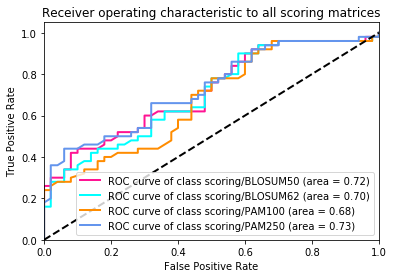

In [36]:
colors = ['deeppink','aqua', 'darkorange', 'cornflowerblue']
for path, color in zip(scoring_files, colors):
    plt.plot(fpr[path], tpr[path], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(path, roc_auc[path]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to all scoring matrices')
plt.legend(loc="lower right")
plt.show()

In [13]:
x = [4,5,6]
test = []
test.append(x)

In [14]:
test

[[4, 5, 6]]

In [134]:
def smith_waterman(path_seq_a, path_seq_b, path_scoring_matrix, gap_open_penalty, gap_extend_penalty):
    #Read sequences and scoring matrix
    name_a, seq_a = read_sequence(path_seq_a)
    name_b, seq_b = read_sequence(path_seq_b)
    scoring = read_scoring_matrix(path_scoring_matrix)
    #Initialize scoring matrix
    dim_a = len(seq_a) +1
    dim_b =len(seq_b)+1
    scoring_matrix = np.zeros((dim_a, dim_b))
    for i in range(1,dim_a):
        for j in range(1,dim_b):
            align_score = scoring[seq_a[i-1],seq_b[j-1]]
            mismatch_score = gap_open_penalty
            if align_score > mismatch_score
    return scoring_matrix
    
    

In [135]:
test = smith_waterman('/Users/elizabeth/Desktop/BMI203_HW3/data/sequences/prot-0035.fa','/Users/elizabeth/Desktop/BMI203_HW3/data/sequences/prot-0034.fa','/Users/elizabeth/Desktop/BMI203_HW3/data/scoring/PAM100',0,0)

['G', 'F', 'P', 'I', 'P', 'D', 'P', 'Y', 'C', 'W', 'D', 'I', 'S', 'F', 'R', 'T', 'F', 'Y', 'T', 'I', 'V', 'D', 'D', 'E', 'H', 'K', 'T', 'L', 'F', 'N', 'G', 'I', 'L', 'L', 'L', 'S', 'Q', 'A', 'D', 'N', 'A', 'D', 'H', 'L', 'N', 'E', 'L', 'R', 'R', 'C', 'T', 'G', 'K', 'H', 'F', 'L', 'N', 'E', 'Q', 'Q', 'L', 'M', 'Q', 'A', 'S', 'Q', 'Y', 'A', 'G', 'Y', 'A', 'E', 'H', 'K', 'K', 'A', 'H', 'D', 'D', 'F', 'I', 'H', 'K', 'L', 'D', 'T', 'W', 'D', 'G', 'D', 'V', 'T', 'Y', 'A', 'K', 'N', 'W', 'L', 'V', 'N', 'H', 'I', 'K', 'T', 'I', 'D', 'F', 'K', 'Y', 'R', 'G', 'K', 'I']


In [137]:
test.shape

(114, 126)

In [138]:
test = read_sequence('/Users/elizabeth/Desktop/BMI203_HW3/data/sequences/prot-0035.fa')

In [139]:
len(test[1])

113